In [1]:
import os
from xml.etree import ElementTree
from bs4 import BeautifulSoup
import seaborn as sns
import collections
import pandas as pd
import xml.etree.ElementTree as ET
import cv2 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import shutil
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import imgaug as ia
import imageio
import re
import numpy as np
from PIL import Image


In [ ]:
!pip install tensorflow-object-detection-api

In [8]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import imutils
from object_detection.utils import ops as utils_ops
import warnings
warnings.filterwarnings('ignore')

We trained Three models for this task and by comparing most of parameter showen in chart below ,came to a conclusion that SSD MobileNet model is best model for final pipeline.

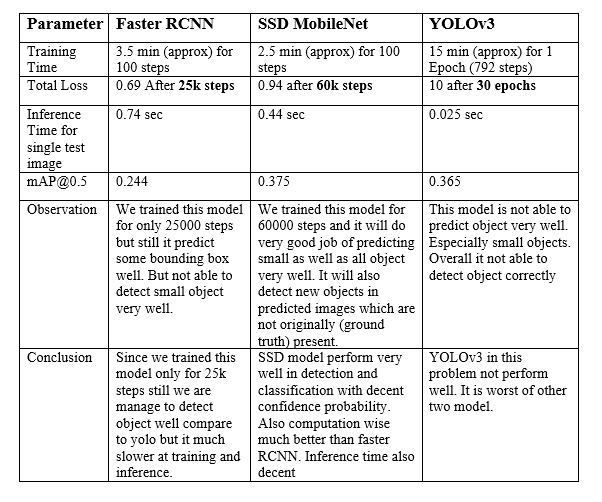

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#link for test images:
#https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/test1.tar.gz

!tar -xf /content/drive/MyDrive/test1.tar

Damage Type :


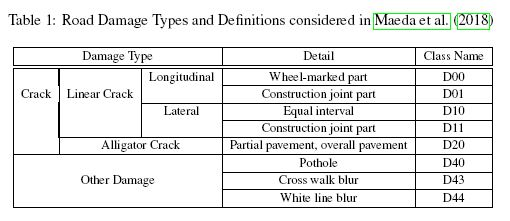

In [ ]:
  '''
  img = Image.open('/content/test1/Japan/images/Japan_000157.jpg') # image extension *.png,*.jpg
  new_width  = 640
  new_height = 640
  img_resize = img.resize((new_width, new_height), Image.ANTIALIAS)
  img_resize.save('test_image.jpg')
  plt.figure(figsize=(5,5))
  plt.imshow(img_resize)
  '''

In [9]:
PATH_TO_MODEL_DIR = '/content/drive/MyDrive/object_detection/mobile_ner_v2_fpnlite_640x640/exporter2'

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 20.302463054656982 seconds


In [10]:

def resize_image(img_path):
  img = Image.open(img_path) # image extension *.png,*.jpg
  new_width  = 640
  new_height = 640
  img_resize = img.resize((new_width, new_height), Image.ANTIALIAS)
  return np.asarray(img_resize)
  #img_resize.save('test_image.jpg')
  #plt.figure(figsize=(5,5))
  #plt.imshow(img_resize)



def final_pipeline(test_img_path ):

  utils_ops.tf = tf.compat.v1
  tf.gfile = tf.io.gfile
  PATH_TO_LABELS = '/content/drive/MyDrive/label_map.pbtxt'

  category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                      use_display_name=True)


  print('Running inference... ')

  image_np = resize_image(test_img_path)
  #print('\nimage shape : ', image_np.shape)
  # Things to try:
  # Flip horizontally
  # image_np = np.fliplr(image_np).copy()

  # Convert image to grayscale
  # image_np = np.tile(
  #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image_np)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  #print(input_tensor.shape)
  input_tensor = input_tensor[tf.newaxis, ...]
  #print(input_tensor.shape)
  # input_tensor = np.expand_dims(image_np, 0)
  detections = detect_fn(input_tensor)
  #print(detections)
  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
  #print('detections : ',detections)
  detections['num_detections'] = num_detections
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
  #print(detections)

  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.29,
        agnostic_mode=False)

  plt.figure(figsize=(10,10))
  plt.title('Detected Image : ')
  plt.imshow(image_np_with_detections)
  print('Done')
  plt.show()

# **Inference :**

Running inference... 
Done
Total execution time for a query point is : 8.637910604476929 sec 


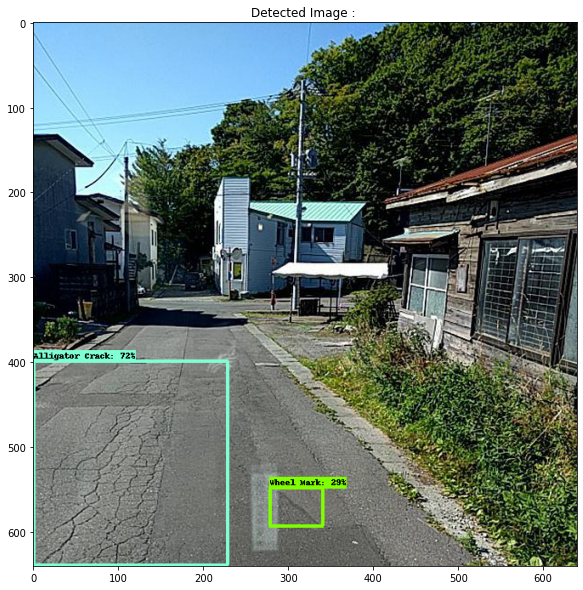

In [11]:
start = time.time()

test_img_path ='/content/test1/Japan/images/Japan_000157.jpg' 

final_pipeline(test_img_path)

end = time.time()
print('Total execution time for a query point is : {} sec '.format((end - start)))

Running inference... 
Done
Total execution time for a query point is : 0.12090635299682617 sec 


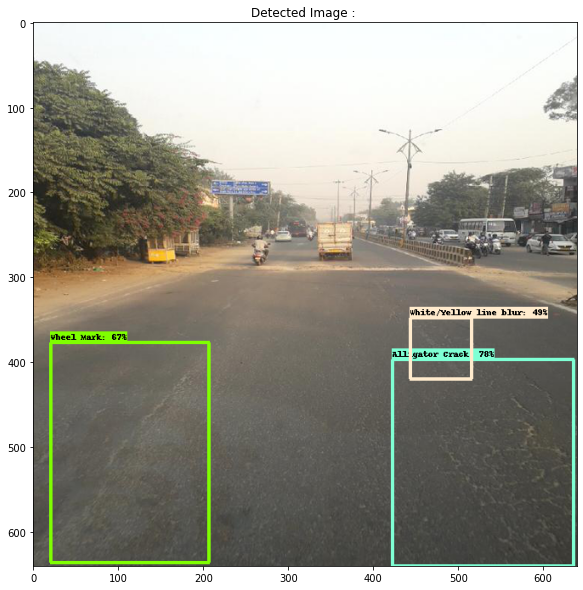

In [12]:
start = time.time()

test_img_path ='/content/test1/India/images/India_000674.jpg' 

final_pipeline(test_img_path)

end = time.time()
print('Total execution time for a query point is : {} sec '.format((end - start)))

Running inference... 
Done
Total execution time for a query point is : 0.09066128730773926 sec 


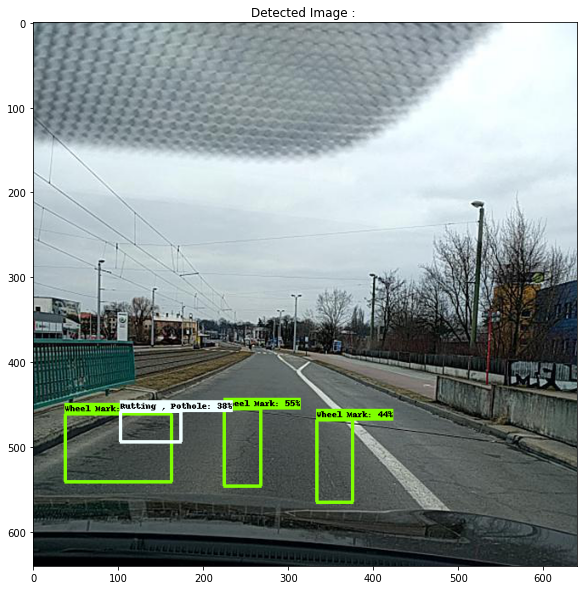

In [13]:
start = time.time()

test_img_path ='/content/test1/Czech/images/Czech_001567.jpg' 

final_pipeline(test_img_path)

end = time.time()
print('Total execution time for a query point is : {} sec '.format((end - start)))

## **Conclusion :**

1. We seen that Model not able to identify multiple object and small or Blur objects very well with good confidance.

2. For this we need to increase training steps i.e. we need to train model for more steps.Also need to try different different augmentation techniques.

3. This work can be used as a baseline, and experiment can be repeted by collecting more images from different countries,under different seasonal condition for better representing each damage class and improving robustness of overall detection system.